# Spark Practical Work

Authors:
 - Ahajjan Ziggaf Kanjaa, Mohammed
 - Labchiri Boukhalef, Younes
 - Ramírez Castaño, Víctor

**(Meter parrafo de descripción del proyecto aqui, que dataset vamos a usar, cual es el problema a resolver y las librerias empleadas)**

### Data loading

In [129]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum, expr, lpad, concat, to_timestamp, date_format
)
from pyspark.sql.types import StringType

spark = SparkSession.builder.appName("FlightModelPrediction").getOrCreate()

data_path = "../training_data/flight_data/2006.csv"

df = spark.read.csv(
    data_path,
    header=True,
    inferSchema=True,
    nullValue="NA"
)

### Explaratory data analysis (EDA)

In [130]:
#Drop the variables that contain information that is unknown at the time the plane takes off

columns_to_drop = [
    "ArrTime", "ActualElapsedTime", "AirTime", "TaxiIn",
    "Diverted", "CarrierDelay", "WeatherDelay",
    "NASDelay", "SecurityDelay", "LateAircraftDelay"
]

df = df.drop(*columns_to_drop)
df = df.na.drop(subset=["ArrDelay"])

df.printSchema()
df.describe().show()

df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
]).show(truncate=False)

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)



+-------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------+------------------+-------+------------------+------------------+------------------+-------+-------+-----------------+------------------+---------+----------------+
|summary|                Year|            Month|        DayofMonth|         DayOfWeek|           DepTime|        CRSDepTime|        CRSArrTime|UniqueCarrier|         FlightNum|TailNum|    CRSElapsedTime|          ArrDelay|          DepDelay| Origin|   Dest|         Distance|           TaxiOut|Cancelled|CancellationCode|
+-------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------+------------------+-------+------------------+------------------+------------------+-------+-------+-----------------+------------------+---------+----------------+
|  count|             7003802|    

+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+---------+----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiOut|Cancelled|CancellationCode|
+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+---------+----------------+
|0   |0    |0         |0        |0      |0         |0         |0            |0        |0      |0             |0       |0       |0     |0   |0       |0      |0        |7003802         |
+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+---------+----------------+



### Feature selection (FSS)

In [131]:
#A cancelled flight is not considered a delay, so that it does not give us useful information.
df = df.filter(col("Cancelled") != 1)
df = df.drop("Cancelled", "CancellationCode")

#If we do not have the attributes 'CRSDepTime' or 'CRSArrTime' we delete that instance
df = df.dropna(subset=["CRSDepTime", "CRSArrTime"])

df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
]).show(truncate=False)

#Drop variables that do not give us useful information
df = df.drop("TailNum", "FlightNum")

+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiOut|
+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+
|0   |0    |0         |0        |0      |0         |0         |0            |0        |0      |0             |0       |0       |0     |0   |0       |0      |
+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+



### New variables

In [ ]:
# 1. Crear el Timestamp de salida programada (más limpio)
df = df.withColumn(
    "CRSDepTS",
    to_timestamp(
        concat(
            col("Year"), 
            lpad(col("Month"), 2, "0"), 
            lpad(col("DayofMonth"), 2, "0"),
            lpad(col("CRSDepTime"), 4, "0")
        ),
        "yyyyMMddHHmm"
    )
)

# 2. Hora real de despegue (FinalDepTS)
df = df.withColumn(
    "FinalDepTS",
    col("CRSDepTS") + (col("DepDelay").cast("int") + col("TaxiOut").cast("int")) * expr("INTERVAL 1 MINUTE")
)

# 3. Hora ESTIMADA de llegada (FinalArrTS)
# IMPORTANTE: Se calcula sumando el tiempo de vuelo programado al despegue programado.
df = df.withColumn(
    "FinalArrTS",
    col("CRSDepTS") + (col("CRSElapsedTime").cast("int") * expr("INTERVAL 1 MINUTE"))
)


# Extraemos hora y minuto, y los pegamos con formato
df = df.withColumn(
    "FinalDepHHMM", 
    date_format(col("FinalDepTS"), "HHmm")
).withColumn(
    "FinalArrHHMM", 
    date_format(col("FinalArrTS"), "HHmm")
)

# Si los necesitas como enteros (aunque perderás el 0 a la izquierda)
df = df.withColumn("FinalDepHHMM", date_format(col("FinalDepTS"), "HHmm").cast("int"))

df.show(5)

In [ ]:
df = df.drop('CRSDepTS', 'FinalDepTS', 'FinalArrTS')

df = df.withColumnRenamed("FinalArrHHMM", "LandingEst")

df = df.withColumnRenamed("FinalDepHHMM", "TakeOffTime")

df.show()


+----+-----+----------+---------+-------+----------+----------+-------------+--------------+--------+--------+------+----+--------+-------+--------+-----------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiOut|FinalDep|FinalArrEst|
+----+-----+----------+---------+-------+----------+----------+-------------+--------------+--------+--------+------+----+--------+-------+--------+-----------+
|2006|    1|        11|        3|    743|       745|      1018|           US|           273|       6|      -2|   ATL| PHX|    1587|     13|     756|       1218|
|2006|    1|        11|        3|   1053|      1053|      1318|           US|           265|      -5|       0|   ATL| PHX|    1587|     19|    1112|       1518|
|2006|    1|        11|        3|   1915|      1915|      2133|           US|           258|     -23|       0|   ATL| PHX|    1587|     11|    1926|       2333|
|2006|    1|        11|        3| 

### Baseline model training

Three baseline models are trained: `LogisticRegression(max_iter=1000)`, `DecisionTreeClassifier()`, and `MLPClassifier(max_iter=500)`. These models are fitted on the feature-selected and scaled training data. Training multiple models at this stage establishes performance benchmarks for comparison and identifies which algorithms are initially more suitable for the dataset before any tuning is applied.

,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(100,)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.For an example usage and visualization of varying regularization, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_alpha.py`.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the classifier will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",'auto'
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when ``solver='sgd'``.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.001
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",500
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True
,"random_state random_state: int, RandomState instance, default=NoneDetermines random number generation for weights and biasinitialization, train-test split if early stopping is used, and batchsampling when solver='sgd' or 'adam'.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",None


### Baseline evaluation

The `evaluate_full()` function is used to evaluate each model on the test set. It calculates standard metrics including accuracy, precision, recall, and F1-score. It also plots a confusion matrix, the ROC curve with AUC, and the precision-recall curve with AUC-PR. These metrics provide a comprehensive overview of each model's performance and allow for a more nuanced understanding of strengths and weaknesses, especially in cases of class imbalance.


====== Logistic Regression (Baseline) ======
Accuracy: 0.7522374429223744
Precision: 0.7458553791887125
Recall: 0.76876931467006
F1-score: 0.7571390206785427

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75      5449
           1       0.75      0.77      0.76      5501

    accuracy                           0.75     10950
   macro avg       0.75      0.75      0.75     10950
weighted avg       0.75      0.75      0.75     10950



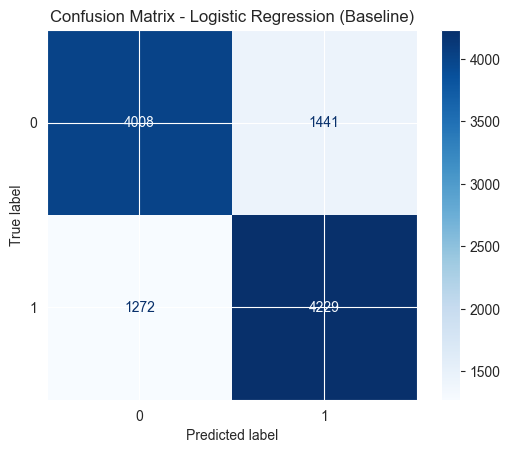

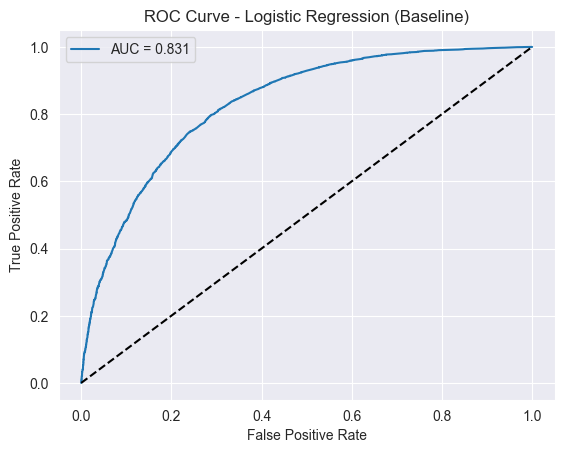

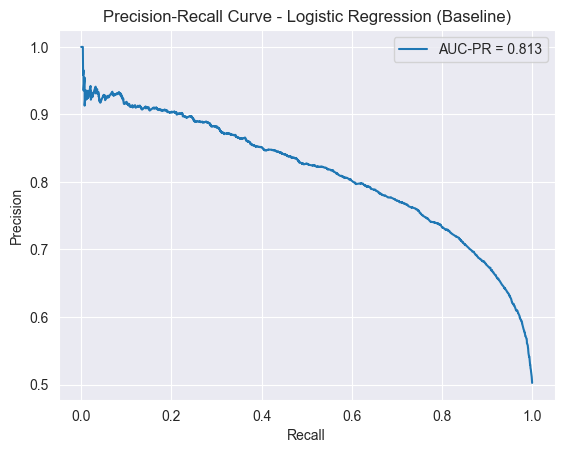


====== Decision Tree (Baseline) ======
Accuracy: 0.712054794520548
Precision: 0.7244741873804972
Recall: 0.6887838574804581
F1-score: 0.7061783617556612

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72      5449
           1       0.72      0.69      0.71      5501

    accuracy                           0.71     10950
   macro avg       0.71      0.71      0.71     10950
weighted avg       0.71      0.71      0.71     10950



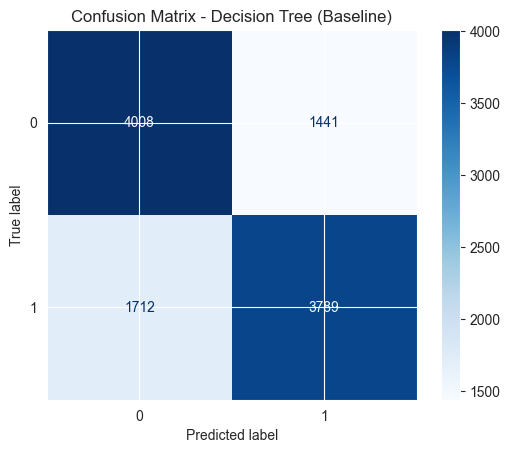

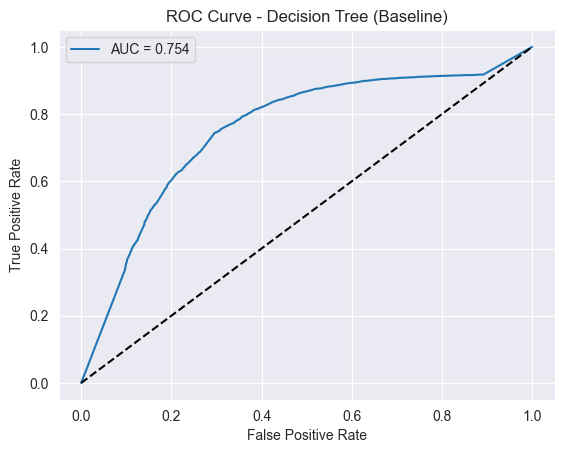

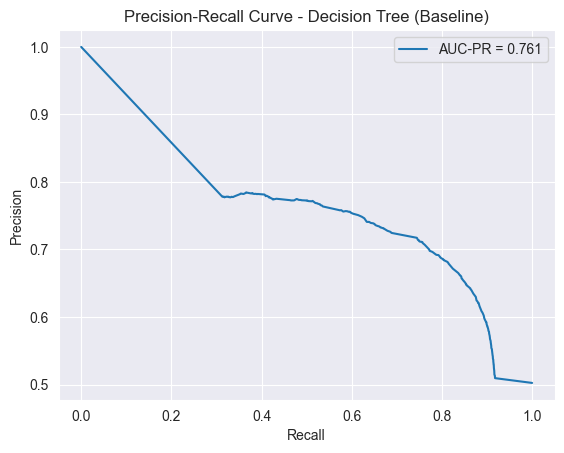


====== Neural Network (Baseline) ======
Accuracy: 0.7542465753424658
Precision: 0.7358173883853643
Recall: 0.7969460098163971
F1-score: 0.7651627541670303

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.71      0.74      5449
           1       0.74      0.80      0.77      5501

    accuracy                           0.75     10950
   macro avg       0.76      0.75      0.75     10950
weighted avg       0.76      0.75      0.75     10950



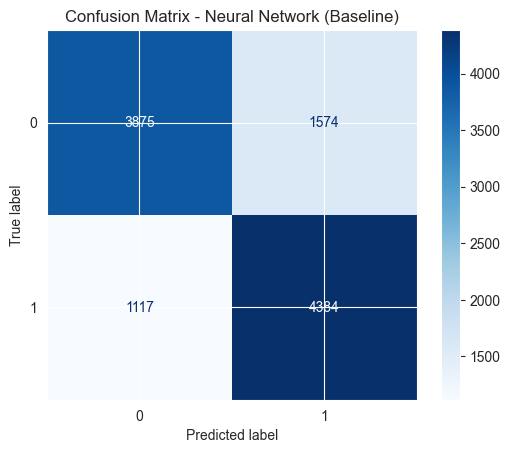

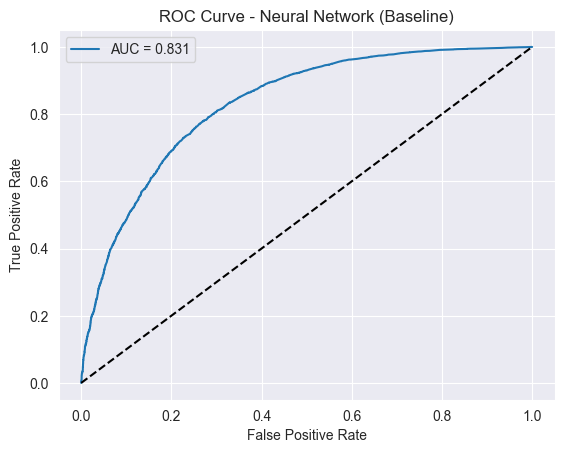

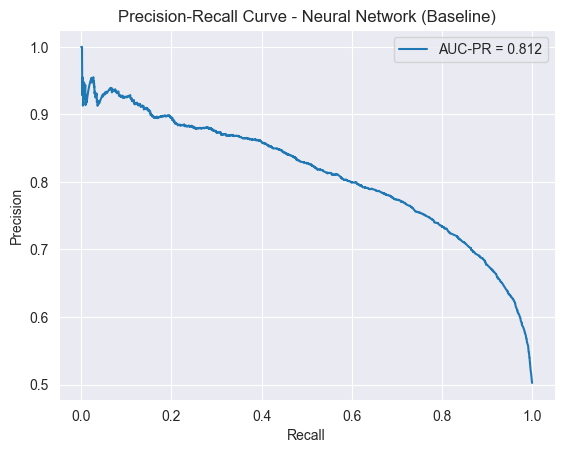

### Hyperparameter tuning

GridSearchCV is used for hyperparameter optimization for each model: logistic regression (`C`, `penalty`, `solver`), decision tree (`max_depth`, `min_samples_split`), and neural network (`hidden_layer_sizes`, `alpha`). The code searches across multiple parameter combinations with 5-fold cross-validation to select the configuration that maximizes accuracy. This step is essential for improving model generalization and ensuring that the final models perform optimally.

C:\Users\youne\Desktop\CiD\S1\Asignaturas\DP\Practica\P2\Notebooks-20251211\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\youne\Desktop\CiD\S1\Asignaturas\DP\Practica\P2\Notebooks-20251211\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
C:\Users\youne\Desktop\CiD\S1\Asignaturas\DP\Practica\P2\Notebooks-20251211\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its de

Best LR params: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best DT params: {'max_depth': 10, 'min_samples_split': 10}
Best MLP params: {'alpha': 0.001, 'hidden_layer_sizes': (64,)}


### Final evaluation

After tuning, the code retrieves the best model via `grid.best_estimator_` and evaluates it on the test set with `accuracy_score` and `classification_report` again. This step confirms how much the optimized model improves over the baseline. Comparing results allows the user to quantify performance gains resulting from hyperparameter optimization and feature selection.


====== Logistic Regression (Tuned) ======
Accuracy: 0.7520547945205479
Precision: 0.7411703601108033
Recall: 0.7782221414288312
F1-score: 0.759244479914871

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.74      5449
           1       0.74      0.78      0.76      5501

    accuracy                           0.75     10950
   macro avg       0.75      0.75      0.75     10950
weighted avg       0.75      0.75      0.75     10950



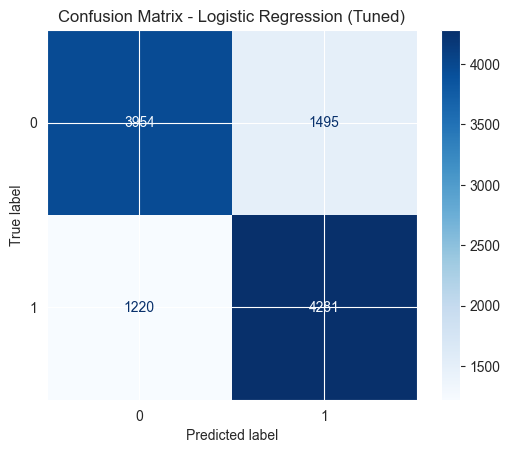

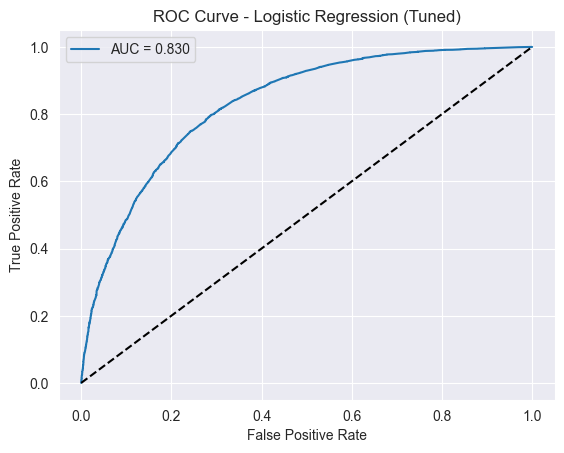

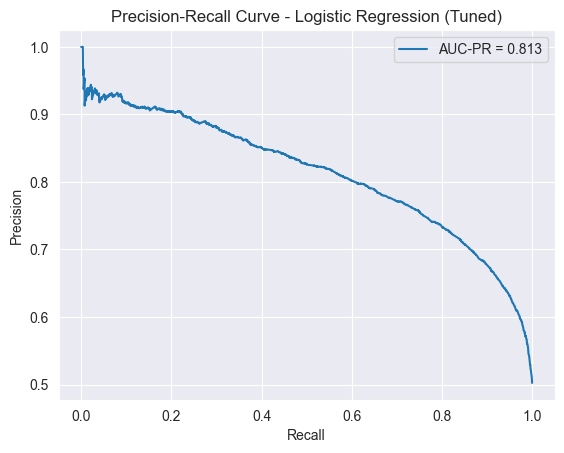


====== Decision Tree (Tuned) ======
Accuracy: 0.7452054794520548
Precision: 0.7303313508920986
Recall: 0.7813124886384294
F1-score: 0.7549622343228526

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.73      5449
           1       0.73      0.78      0.75      5501

    accuracy                           0.75     10950
   macro avg       0.75      0.75      0.74     10950
weighted avg       0.75      0.75      0.74     10950



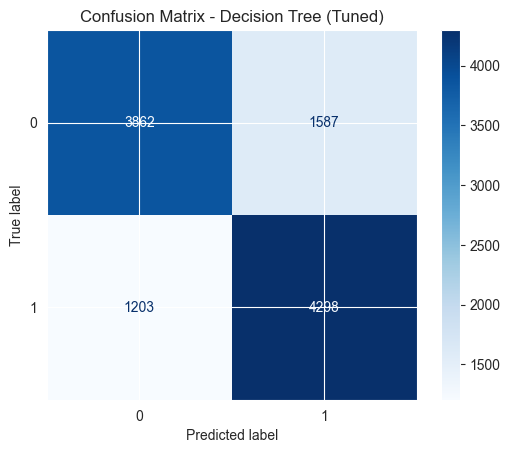

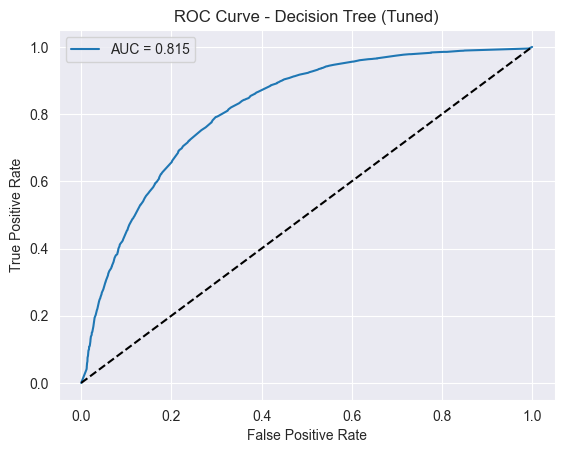

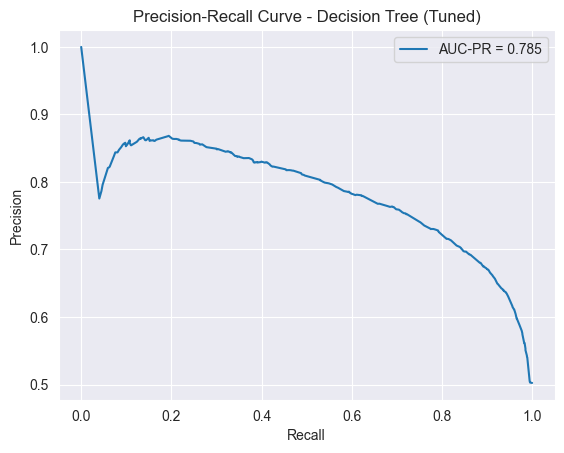


====== Neural Network (Tuned) ======
Accuracy: 0.7546118721461187
Precision: 0.736232370718603
Recall: 0.7971277949463734
F1-score: 0.7654708911582438

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.71      0.74      5449
           1       0.74      0.80      0.77      5501

    accuracy                           0.75     10950
   macro avg       0.76      0.75      0.75     10950
weighted avg       0.76      0.75      0.75     10950



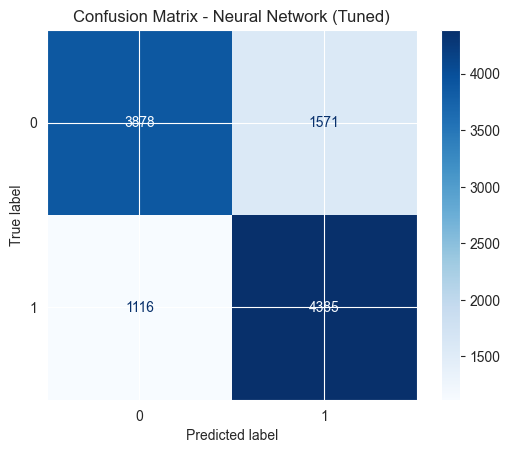

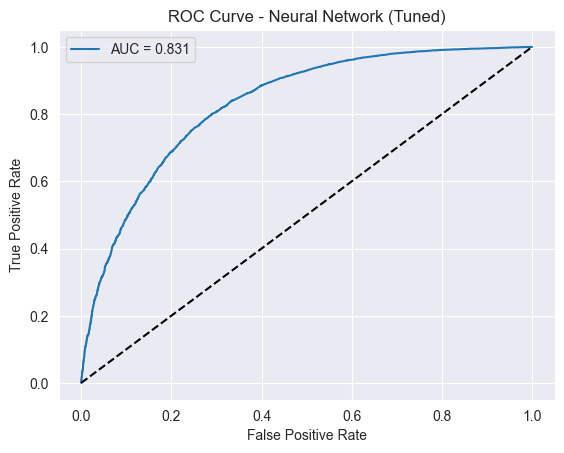

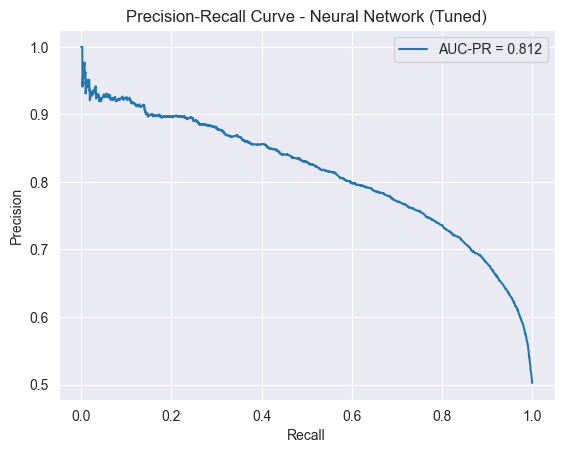

### Interpretability

For interpretability, the logistic regression coefficients (betas) are extracted from `best_lr.coef_` and plotted as a horizontal bar chart to visualize the influence of each feature. The decision tree is visualized using `plot_tree()` to show the full branching structure, feature thresholds, Gini impurity, and leaf outcomes. These visualizations help understand how the models make predictions and identify the most important features driving classification decisions

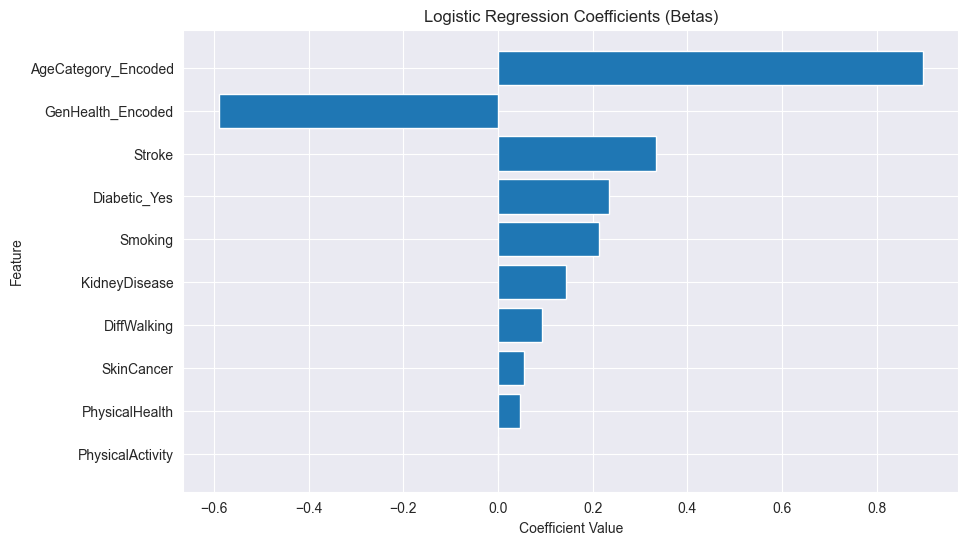

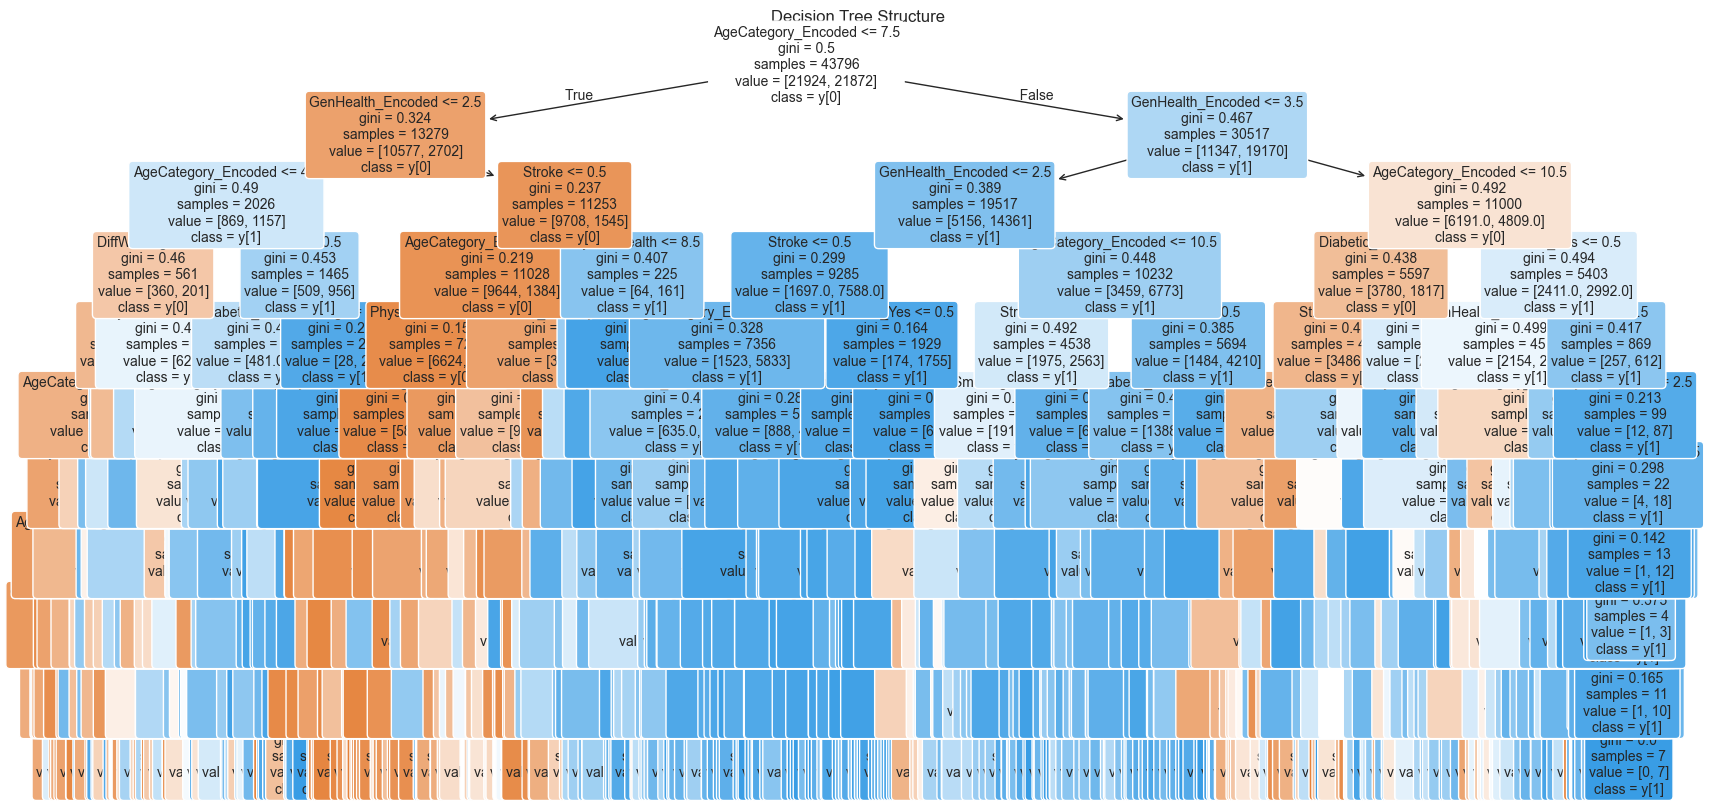

### Comparison Before vs After Tuning

This section summarizes the key metrics (accuracy, precision, recall, F1-score) for all three models in a pandas DataFrame. It compares baseline and tuned models side by side, allowing a clear overview of the improvements achieved through feature selection and hyperparameter tuning. This comparative analysis helps identify which model benefits the most from tuning and provides actionable insights for model selection.

,accuracy,precision,recall,f1
LR Baseline,0.752237,0.745855,0.768769,0.757139
LR Tuned,0.752055,0.741170,0.778222,0.759244
DT Baseline,0.712055,0.724474,0.688784,0.706178
DT Tuned,0.745205,0.730331,0.781312,0.754962
MLP Baseline,0.754247,0.735817,0.796946,0.765163
MLP Tuned,0.754612,0.736232,0.797128,0.765471
